In [1]:
#setup
import warnings; warnings.simplefilter('ignore')
%matplotlib notebook
# set this to your working directory
WORKING_DIR = '/home/elliott/Dropbox/_Ash_Teaching/2018-09 - Bocconi - Text Data and ML/code'
import os
os.chdir(WORKING_DIR)
import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=10000,
                        stop_words='english',
                        ngram_range=(1,3))
X = vec.fit_transform(df1['snippet'])
pd.to_pickle(X,'X.pkl')
vocabdict = vec.vocabulary_
vocab = [None] * len(vocabdict) 
for word,index in vocabdict.items():
    vocab[index] = word
pd.to_pickle(vocab,'vocab.pkl')

In [2]:
# tf-idf weights
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=0.9,  # at most 90% of docs
                        max_features=1000,
                        stop_words='english',
                        use_idf=True,
                        ngram_range=(1,3))

X_tfidf = tfidf.fit_transform(df1['snippet'])
pd.to_pickle(X_tfidf,'X_tfidf.pkl')

<IPython.core.display.Javascript object>


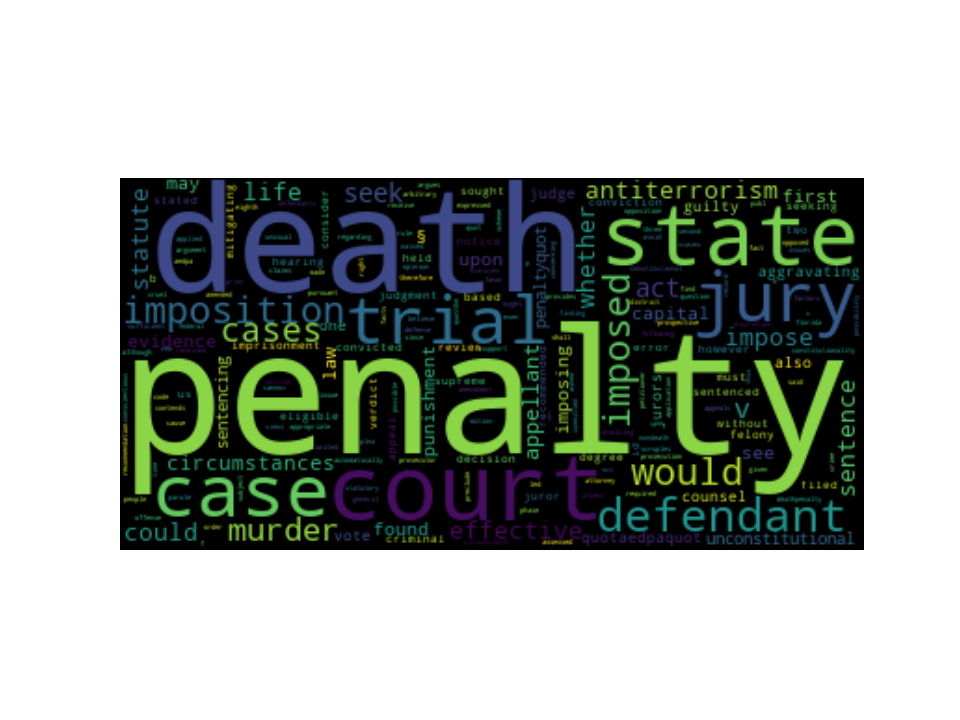

In [3]:
# Our first word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from utils import get_docfreqs

# generate document counts for each word
f = get_docfreqs(df1['snippet']) 
# generate word cloud of words with highest counts
wordcloud = WordCloud().generate_from_frequencies(f) 

plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.show()

In [4]:
#####
# POS tagging 
#####
text = 'Science cannot solve the ultimate mystery of nature. And that is because, in the last analysis, we ourselves are a part of the mystery that we are trying to solve.'

from nltk.tag import perceptron
from nltk import word_tokenize
tagger = perceptron.PerceptronTagger()
tokens = word_tokenize(text)
tagged_sentence = tagger.tag(tokens)
tagged_sentence

[('Science', 'NN'),
 ('can', 'MD'),
 ('not', 'RB'),
 ('solve', 'VB'),
 ('the', 'DT'),
 ('ultimate', 'JJ'),
 ('mystery', 'NN'),
 ('of', 'IN'),
 ('nature', 'NN'),
 ('.', '.'),
 ('And', 'CC'),
 ('that', 'DT'),
 ('is', 'VBZ'),
 ('because', 'RB'),
 (',', ','),
 ('in', 'IN'),
 ('the', 'DT'),
 ('last', 'JJ'),
 ('analysis', 'NN'),
 (',', ','),
 ('we', 'PRP'),
 ('ourselves', 'PRP'),
 ('are', 'VBP'),
 ('a', 'DT'),
 ('part', 'NN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('mystery', 'NN'),
 ('that', 'IN'),
 ('we', 'PRP'),
 ('are', 'VBP'),
 ('trying', 'VBG'),
 ('to', 'TO'),
 ('solve', 'VB'),
 ('.', '.')]

<IPython.core.display.Javascript object>


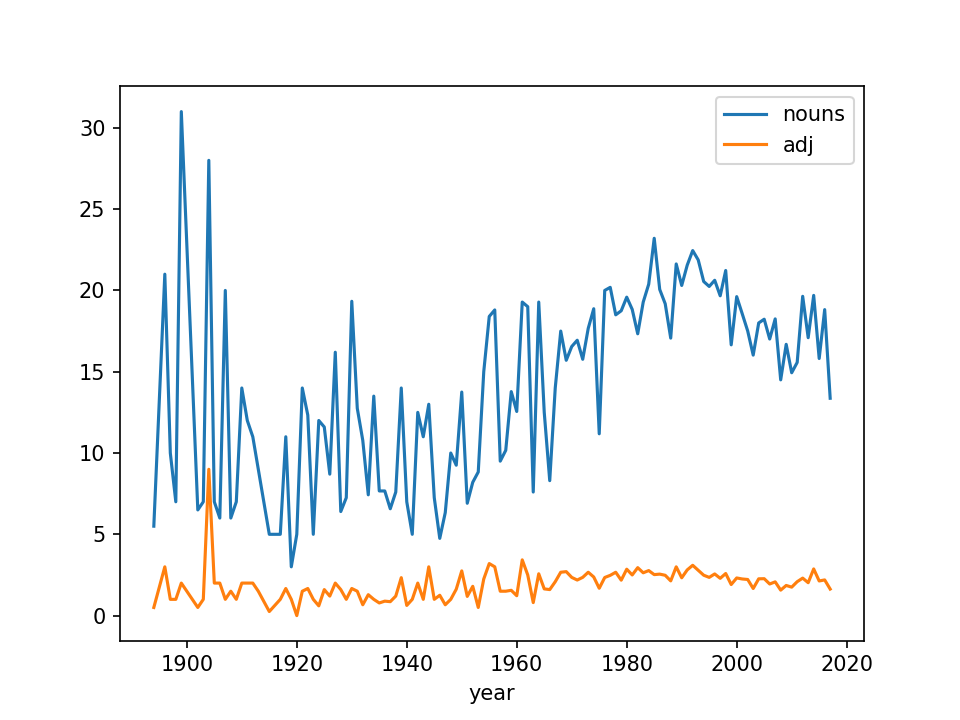

In [5]:
#####
# Our first visualization
# Plot nouns and adjectives over time
#####
from collections import Counter
from nltk import word_tokenize

def get_nouns_adj(snippet):
    tags = [x[1] for x in tagger.tag(word_tokenize(snippet))]
    num_nouns = len([t for t in tags if t[0] == 'N'])
    num_adj = len([t for t in tags if t[0] == 'J'])
    return num_nouns, num_adj

dfs = df1.sample(frac=.1)
dfs['nouns'], dfs['adj'] = zip(*dfs['snippet'].map(get_nouns_adj))
dfs.groupby('year')[['nouns','adj']].mean().plot()

In [ ]:
# Get list of nouns, adjectives, and verbs from WordNet
from nltk import wordnet as wn
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.add('well')

full_vocab = set()

for x in wn.wordnet.all_synsets('a'):
    full_vocab.add(x.lemma_names()[0].lower())
for x in wn.wordnet.all_synsets('n'):
    full_vocab.add(x.lemma_names()[0].lower())
for x in wn.wordnet.all_synsets('v'):
    full_vocab.add(x.lemma_names()[0].lower())

full_vocab = full_vocab - stop

pd.to_pickle(full_vocab,'full_vocab.pkl')

In [6]:
# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
polarity = sid.polarity_scores(text)
polarity

{'neg': 0.105, 'neu': 0.895, 'pos': 0.0, 'compound': -0.2924}

In [7]:
def get_sentiment(snippet):
    return sid.polarity_scores(snippet)['compound']
dfs['sentiment'] = dfs['snippet'].apply(get_sentiment)
dfs.sort_values('sentiment',inplace=True)
list(dfs[:2]['snippet'])

['leaning toward the death penalty but I felt discomfort about imposing the death penalty. If I was going & ;to give him the death penalty.&quot;\n&quot;My reasons for voting for the death penalty were these: based& ;supported the death penalty, they were assured that it was proper to impose the death penalty on defendant& ;leaning toward the death penalty but I felt discomfort about imposing the death penalty. If I was going & ;a stupid deal, instead of ... giving me the death penalty. They gave me a dumb deal for six life sentences',
 'impose the death penalty but testified as follows:\nWell, my attitude toward the death penalty is that \x97& ; from voting for the death penalty even though she might think the death penalty was warranted.\nThe court& ;defendant was found guilty as charged and given the death penalty on each count. This is the direct appeal of & ;decision of one or more jurors to impose the death penalty.\nState v. Lee, supra at  .\nThis case is distinguishable& ;contr

In [8]:
list(dfs[-2:]['snippet'])

['actually imposed. Were it otherwise neither the death penalty nor a natural life sentence without possibility& ; did not intend the document to abolish the death penalty in Illinois, since a separate referendum regarding& ; for approval [Citation omitted.] Since the death penalty is the antithesis of rehabilitative sentencing& ; -year-old person was &quot;tantamount to a death penalty.&quot; And in People v. Rogers ( ),   Ill',
 'jury&# ;s decision as to whether or not the death penalty should be imposed.&quot;\nId. at  ,   S.E& ;particular case at hand warrant imposition of the death penalty.\nGreen,   N.C. at  ,   S.E. d at  . This& ; the capricious or random imposition of the death penalty.&quot; State v. Barfield,   N.C.  ,  ,& ;S.Ct.  ,   L.Ed. d   ( ). Whether the death penalty is disproportionate &quot;ultimately rest[s]& ;similar to cases in which we have found the death penalty proportionate. In State v. Harden,   N.C. ']

In [9]:
##########
# N-grams
#####
from nltk import ngrams

# get n-gram counts for 10 documents
grams = []
for i, row in df1.iterrows():
    tokens = row['snippet'].lower().split() # get tokens
    for n in range(2,4):
        grams += list(ngrams(tokens,n)) # get bigrams, trigrams, and quadgrams
    if i == 10:
        break
Counter(grams).most_common()[:8]  # most frequent n-grams

[(('death', 'penalty'), 38),
 (('the', 'death'), 34),
 (('the', 'death', 'penalty'), 25),
 (('death', 'penalty.'), 8),
 (('in', 'the'), 8),
 (('of', 'the'), 7),
 (('the', 'death', 'penalty.'), 6),
 (('(', ')'), 5)]

In [10]:
###
# Collocations: Point-Wise Mutual Information
###
from operator import mul
from functools import reduce
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def get_gmean(phrase, termfreqs):
    words = phrase.split('_')
    n = len(words)
    p = [termfreqs[w]**(1/n) for w in words]
    numerator = termfreqs[phrase]   
    denominator = reduce(mul, p)
    if denominator == 0:
        return 0
    gmean = numerator / denominator
    return gmean

In [11]:
###
# POS-filtered N-grams
###
# Normalize Penn tags
tagdict = { 'NN':'N',
            'NNS':'N',
                                    
            'JJ':'A',
            'JJR':'A',
            'JJS':'A',
            'VBG':'A', # gerunds/participles treated like adjectives

            'RB':'A', # adverbs treated as adjectives
            'RBR':'A',
            'RBS':'A',
            'PDT':'A', # predeterminer            

            'VB':'V',
            'VBD':'V',
            'VBN':'V',
            'VBP':'V',
            'VBZ':'V',
            'MD': 'V', # modals treated as verbs
            'RP': 'V', # particles treated as verbs
            
            'DT':'D',
                        
            'IN':'P',
            'TO':'P',

            'CC': 'C'}

tagpatterns = {'A','N','V','P','C','D',
           'AN','NN', 'VN', 'VV', 
            #'NV',
            'VP',                                    
            'NNN','AAN','ANN','NAN','NPN',
            'VAN','VNN', 'AVN', 'VVN',
            'VPN', 'VDN', 
            #'ANV','NVV','VVV', 'NNV',
            'VVP','VAV','VVN',
            'NCN','VCV', 'ACA',  
            'PAN',
            'NCVN','ANNN','NNNN','NPNN', 'AANN' 'ANNN','ANPN','NNPN','NPAN', 
            'ACAN', 'NCNN', 'NNCN', 'ANCN', 'NCAN',
            'PDAN', 'PNPN',
            'VDNN', 'VDAN','VVDN'}

max_phrase_length = 4

termfreqs = Counter()

docs = pd.read_pickle('processed_corpus.pkl')

for i, doc in enumerate(docs.values()):
    if i > 2000:
        break
    for sentence in doc:    
        # split into words and get POS tags
        tagwords = []
        for (word,tag) in tagger.tag(sentence):
            if tag in tagdict:
                normtag = tagdict[tag]
                stemmed = word#stemmer.stem(word)
                tagwords.append((stemmed,normtag))
            else:
                tagwords.append(None)
        for n in range(1,max_phrase_length+1):            
            rawgrams = ngrams(tagwords,n)
            for rawgram in rawgrams:
                # skip grams that have rare words
                if None in rawgram:
                    continue
                gramtags = ''.join([x[1][0] for x in rawgram])
                if gramtags in tagpatterns:
                     # if tag sequence is allowed, add to counter
                    gram = '_'.join([x[0] for x in rawgram])
                    termfreqs[gram] += 1

# filter out unigrams
grams = [x for x in termfreqs.most_common() if '_' in x[0]]
# make dataframe of geometric mean associations for each gram
gmeans = pd.DataFrame([(gram[0], get_gmean(gram[0],termfreqs)) for gram in grams],
              columns=['ngram','gmean'])
gmeans.sort_values('gmean')

,ngram,gmean
10268,___,0.000000
9394,penalty_of_death,0.000144
8168,death_penalty_and_death,0.000159
8169,penalty_and_death_penalty,0.000159
8166,penalty_and_death,0.000179
5182,s_the_death_penalty,0.000196
7688,not_death_penalty,0.000206
11334,death_&_quot,0.000212
3927,has_the_death_penalty,0.000227
5181,s_the_death,0.000236


In [4]:
# Dependency Parsing
import spacy
nlp = spacy.load('en')
doc = nlp(text)
for sent in doc.sents:
    print(sent)
    print(sent.root)
    print([(w, w.dep_) for w in sent.root.children])
    print()

NameError: name 'text' is not defined

In [3]:
sent

NameError: name 'sent' is not defined

In [6]:
text = 'Science cannot solve the ultimate mystery of nature. And that is because, in the last analysis, we ourselves are a part of the mystery that we are trying to solve.'
import spacy
nlp = spacy.load('en')
doc = nlp(text)

In [7]:
doc

Science cannot solve the ultimate mystery of nature. And that is because, in the last analysis, we ourselves are a part of the mystery that we are trying to solve.

In [9]:
for sent in doc.sents:
    print(sent)
    print(sent.root)
    print([(w, w.dep_) for w in sent.root.children])
    print()

Science cannot solve the ultimate mystery of nature.
solve
[(Science, 'nsubj'), (can, 'aux'), (not, 'neg'), (mystery, 'dobj'), (., 'punct')]

And that is because, in the last analysis, we ourselves are a part of the mystery that we are trying to solve.
is
[(And, 'cc'), (that, 'nsubj'), (are, 'advcl'), (., 'punct')]



In [10]:
sent

And that is because, in the last analysis, we ourselves are a part of the mystery that we are trying to solve.

In [11]:
sent.root

is

In [13]:
list(sent.root.children)

[And, that, are, .]

In [14]:
sent

And that is because, in the last analysis, we ourselves are a part of the mystery that we are trying to solve.

In [15]:
sent[0]

And

In [16]:
sent[0].dep_

'cc'

In [18]:
sent[0].head

is